# ROC curves, AUC (area under the curve) and MCC (Matthews' correlation coefficient)

In this notebook, we illustrate how to:

1. draw the ROC curve
2. calculate the AUC (area under the curve)
3. claculate the MCC (Matthew's correlation coefficient)

## Loading libraries

First of all, we load some necessary general libraries:

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Get the data

We are using results from a mock binary classification problem.
This was based on the [breast cancer Wisconsin dataset](https://github.com/scikit-learn/scikit-learn/blob/6e9039160f0dfc3153643143af4cfdca941d2045/sklearn/datasets/data/breast_cancer.csv) from the Python library `sklearn`.

In this dataset, the objective is to diagnose the status of breast cancer:

- `0`: malignant cancer
- `1`: benign cancer

The dataset contains **569 examples**:

- 212 malignant
- 357 benign

And the prediction (classification) is based on 30 numeric features related to the cancer lesions (size, shape etc.: full description can be found [here](https://scikit-learn.org/1.5/datasets/toy_dataset.html#breast-cancer-dataset)).

Actually, in this example we used a random subset of the 30 features, by selecting 8 features: in this way, the problem was harder, and we obtained more classification errors, which is instrumental to the illustration of different metrics to measure model performance.

The dataset is imbalanced: the ratio between the two classes is not 1, but 0.6.
Again, this is instrumental in showing the relative advantage of using different performance metrics rather than just looking at the error rate / overall accuracy.

An 80% / 20% training / test data split was used to train the classification model and measure performance: the **test results** are used here to show ROC curves, AUC and MCC.

In [41]:
DATASET_URL = 'https://raw.githubusercontent.com/ne1s0n/bioinformateachers/refs/heads/main/dlb/data/predictions.csv'

The dataframe contains:

- the **original test observation** (the "truth": malignant or benign)
- the **predicted class** (binary)
- the **two probabilities**: of being '0' (malignant) or '1' (benign)

In [42]:
bc_data = pd.read_csv(DATASET_URL)
bc_data.head()

,y_test,y_pred,prob_0,prob1
0,1.0,1.0,0.013791,0.986209
1,1.0,1.0,0.022589,0.977411
2,1.0,1.0,0.340036,0.659964
3,0.0,0.0,0.999988,0.000012
4,1.0,1.0,0.029998,0.970002


The test dataset was generated by taking a 20% random subset of the data: **114 test examples**.

In [43]:
len(bc_data)

114

---

Let's get a look at the original **confusion matrix**: first we get the two vectors of predictions and observations, and then construct the matrix of correct predictions (diagonal) and errors (off diagonal).

In [44]:
y_test = np.array(bc_data['y_test'])
y_pred = np.array(bc_data['y_pred'])

In [45]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[34,  7],
       [ 4, 69]])

---

The next step will be to bring the **probabilities of prediction** in the game, not just the predicted classes.

Keep in mind that the predicted classes have been obtained based on the **0.5 threshold**: each test example is attributed to the class whose probability is larger than 50%.

In [46]:
y_probs = np.array(bc_data[bc_data.columns[2:4]])
print(y_probs[0:5,:])

[[1.37907635e-02 9.86209236e-01]
 [2.25887425e-02 9.77411258e-01]
 [3.40035689e-01 6.59964311e-01]
 [9.99988475e-01 1.15251572e-05]
 [2.99984697e-02 9.70001530e-01]]


---

### ROC curves

This is a binary classification problem, therefore the model usually focuses on the probability for just one class (being the other unambiguously obtained as reciprocal to 1).
Most commonly, the probability of class `1` ("case") is modeled:

$$
P(y=1 | X)
$$

Therefore, this probability is used in the calculation of the **ROC curve**.

In [47]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [48]:
prob_y_eq_1 = y_probs[:,1]

The **ROC curve** is based on looking at classification results from the perspective of all (many) classification thresholds, not just the standard 50%.

This means that probabilities ($P(y=1)$) are evaluated against threshold 0%, 0.5% 10% $\ldots$ 90%, 95%, 100%): for each threshold the **false positive rate** (FP/(FP+TN)) and the **true positive rate** (TP/(TP+FN) = 1-FNR) are calculated and then plotted against each other.

The function `roc_curve` from `sklearn` takes in input the correct test labels (the "truth") and the prediction probabilities obtained from the classification model.

This function returns the ingredients needed to draw the ROC curve: the FPR and TPR calculated against several classification thresholds (by default, 20 thresholds are considered):

In [49]:
fpr, tpr, thrs = roc_curve(y_test, prob_y_eq_1)

We obtain **20 values** for **FPR** and for **TPR**:

In [50]:
len(fpr)

20

In [51]:
df = pd.DataFrame(np.vstack((fpr,tpr)).T, columns=['FPR','TPR'])
df.head(10)

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.013699
2,0.000000,0.219178
3,0.024390,0.219178
4,0.024390,0.561644
5,0.048780,0.561644
6,0.048780,0.780822
7,0.073171,0.780822
8,0.073171,0.890411
9,0.097561,0.890411


We now have all the elements to plot the ROC curve for this classification problem.

Typically, a ROC curve is visually contrasted against chance accuracy, which for a binary classification problem is 50%, and it is represented by a straight line bisecting the plot:

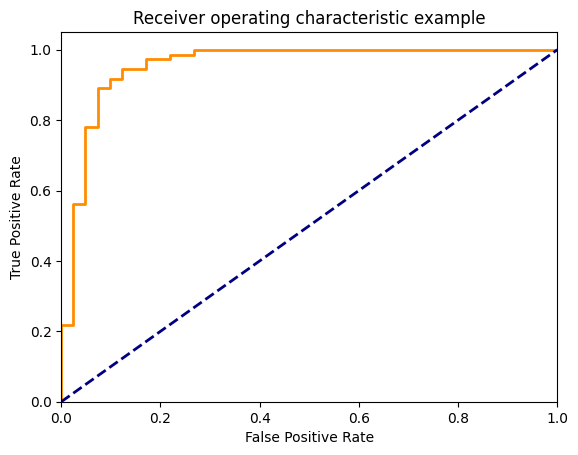

In [52]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    #label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
#plt.legend(loc="lower right")
plt.show()

Ideally, the ROC curve of the chose classification model should be as close as possible to the **top left corner** of the above plot; conversely, the closer the ROC curve gets to the dashed line (chance accuracy), the worse the performance of the model.

### AUC

The area under the (ROC) curve -the **AUC**- provides a summary numeric score for the model performance, in terms of **True** and **False Positive Rates**, over **multiple classification thresholds**.

This is a very effective way of summarising the information visually conveyed by the plot of the ROC curve:

- if the ROC curve follows exactly the left top corner of the plot, we have perfect classification accuracy, and the AUC is 100% (**AUC = 1** : the entire plotting area is under the ROC curve)
- if the ROC curve is collapsed with the diagonal bisecting the plot, we have perfect chance accuracy, and the AUC is 50% (**AUC = 0.5**); our classification modes is no better than tossing a coin in making predictions!

Intuitively, the higher the AUC the better the binary classification model.
However, what is to be considered a good AUC score obvioulsy depends a lot on the specific classification problem at hand.
Generally speaking, **AUC > 0.8** usually indicates a good model performance.

In [53]:
roc_auc = auc(fpr, tpr)

In [54]:
print("AUC is", round(roc_auc,3))

AUC is 0.956


We can easily add the AUC value to the ROC curve plot:

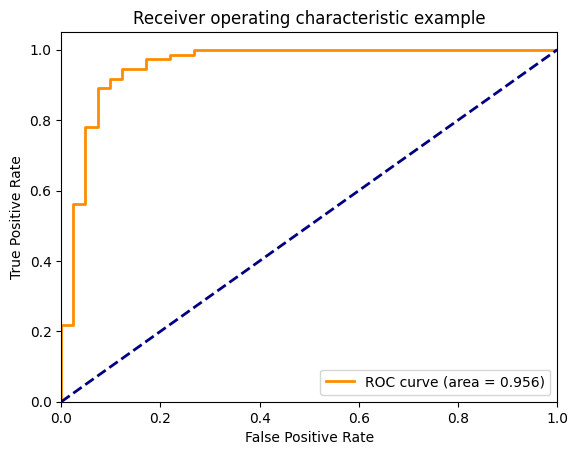

In [56]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.3f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [31]:
accuracy = (y_test == y_pred).sum()/len(y_test)
print(round(accuracy, 3))

0.904


In [33]:
n_positives = len(bc_data[bc_data["y_test"]==1])
n_negatives = len(bc_data[bc_data["y_test"]==0])

print("N. of positive test examples:", n_positives)
print("N. of negative test examples:", n_negatives)

N. of positive test examples: 73
N. of negative test examples: 41


In [38]:
true_positive_preds = len(bc_data[(bc_data.y_test==1) & (bc_data.y_pred == 1)])
true_negative_preds = len(bc_data[(bc_data.y_test==0) & (bc_data.y_pred == 0)])

tpr = true_positive_preds/n_positives
tnr = true_negative_preds/n_negatives

print("TPR is:", round(tpr,3))
print("TNR is:", round(tnr,3))

TPR is: 0.945
TNR is: 0.829


### MCC

[TODO]